# OHP_2_Alignement_Stack

[Version Hervé Dole, Université Paris-Saclay - 20240324]

Thanks to Henry J McCracken and M2 astrophysique AAIS IDF OHP1 team for inspiration on some code lines

Aligne les images d'une source dans le même filtre puis les stacke (coadd) afin d'obtenir l'image finale.

Faire tourner ce notebook après OHP_1_... 


In [150]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os 
import glob
import astroalign as aa
from astropy.io import fits
import astropy.io.fits.header as header
from matplotlib.colors import LogNorm
from ccdproc import cosmicray_lacosmic as lacosmic
#from astroscrappy import detect_cosmics as lacosmic
# this is necessary because the version in CCDPROC is calling the wrong arguments. 
#import aplpy

### Define here working directories

In [151]:
data_dir = "./data/"
data_dir2 = "./data2/"
data_dir3 = "./data3/"
output_dir = "./"

### Define filenames here [choose only one filter at a time, e.g. r or g]

In [152]:
# Inputs

# filtre r
input_data_list = data_dir3 + 'PSZ1-cluster*_R*processed.fits'

# filtre g
#input_data_list = data_dir3 + 'PSZ1-cluster*_G*processed.fits'

In [153]:
# Outputs
stacked_data_outfile = '_stacked'

## 1. List of processed images to align

In [154]:
image_list = glob.glob(input_data_list)

In [155]:
image_list

['./data3/PSZ1-cluster-0006_R_processed.fits',
 './data3/PSZ1-cluster-0002_R_processed.fits',
 './data3/PSZ1-cluster-0007_R_processed.fits',
 './data3/PSZ1-cluster-0001_R_processed.fits']

In [156]:
# get number of images to stack
n_images = len(image_list)

## 2. Select target image for alignement

In [157]:
target_image = image_list[0]
print(target_image)
target=fits.open(target_image)[0].data

./data3/PSZ1-cluster-0006_R_processed.fits


In [158]:
# Not ready
# clean for cosmic rays
#target_cleanedcosmic, mask=lacosmic(target)

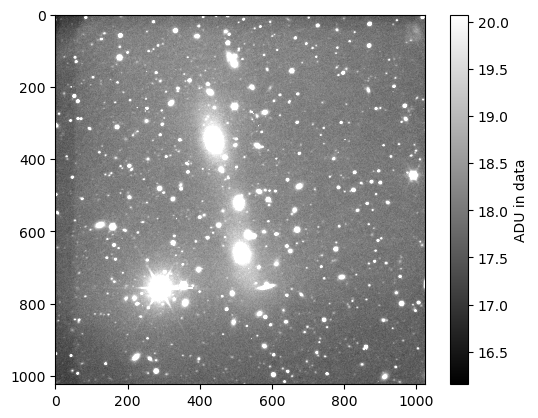

In [159]:
# show target image
sig = 0.2
m, s = np.median(target), np.std(target)
plt.imshow(target, cmap='gray', vmin=m-sig*s, vmax=m+sig*s)
plt.colorbar(label="ADU in data")

In [160]:
# Show data statistics - for checks
print("median: ", np.median(target))
print("mean: ", np.mean(target))
print("stdev: ", np.std(target))
print("min: ", np.min(target))
print("max: ", np.max(target))

median:  18.115807
mean:  18.68316
stdev:  9.811971
min:  4.696839
max:  327.6344


## 3. Register all images and align them to target

Go through the list of files, register them, and add them together. 

In [161]:
target_fixed = np.array(target, dtype="<f4")
image_concat = [target]
for image in image_list:
    print ("registering image ",image)
    source = fits.open(image)[0].data
    source_fixed = np.array(source, dtype="<f4")

    registered_image, footprint = aa.register(source_fixed,target_fixed, detection_sigma=3)
    image_concat.append(registered_image)

registering image  ./data3/PSZ1-cluster-0006_R_processed.fits
registering image  ./data3/PSZ1-cluster-0002_R_processed.fits
registering image  ./data3/PSZ1-cluster-0007_R_processed.fits
registering image  ./data3/PSZ1-cluster-0001_R_processed.fits


## 4. Now stack them using median to get stacked image

In [162]:
final_image = np.median(image_concat, axis=0)

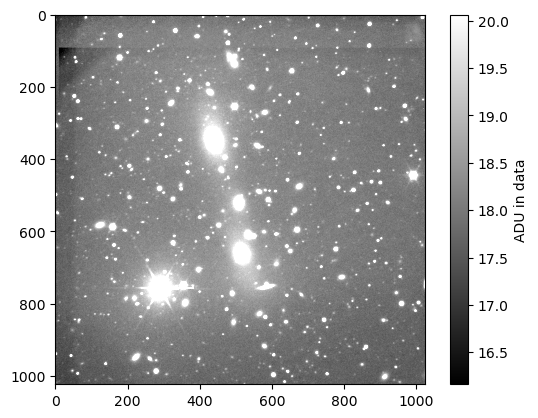

In [163]:
# show target image
sig = 0.2
m, s = np.median(final_image), np.std(final_image)
plt.imshow(final_image, cmap='gray', vmin=m-sig*s, vmax=m+sig*s)
plt.colorbar(label="ADU in data")

In [164]:
# Show data statistics - for checks
print("median: ", np.median(final_image))
print("mean: ", np.mean(final_image))
print("stdev: ", np.std(final_image))
print("min: ", np.min(final_image))
print("max: ", np.max(final_image))

median:  18.112608
mean:  18.673315
stdev:  9.750256
min:  4.696839
max:  327.62933


## 5. Write final stacked image

In [165]:
# output filename
filename,file_extension=os.path.splitext(target_image)
outfile=output_dir+os.path.basename(filename)+stacked_data_outfile+'.fits'
outfile

'./PSZ1-cluster-0006_R_processed_stacked.fits'

In [166]:
# fits attributes stacked
hdu = fits.PrimaryHDU(final_image)
hdr = hdu.header
# Update minimalist header
hdr['HISTORY'] = 'Written by OHP_2_Alignement_Stack'
hdr['HISTORY'] = str(n_images)+' images stacked'
#write output fits file
hdu.writeto(outfile, overwrite=True)